<a href="https://www.kaggle.com/code/dataranch/cpu-gpu-stats-feature-importance?scriptVersionId=110055524" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**CPU + GPU Stats | Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

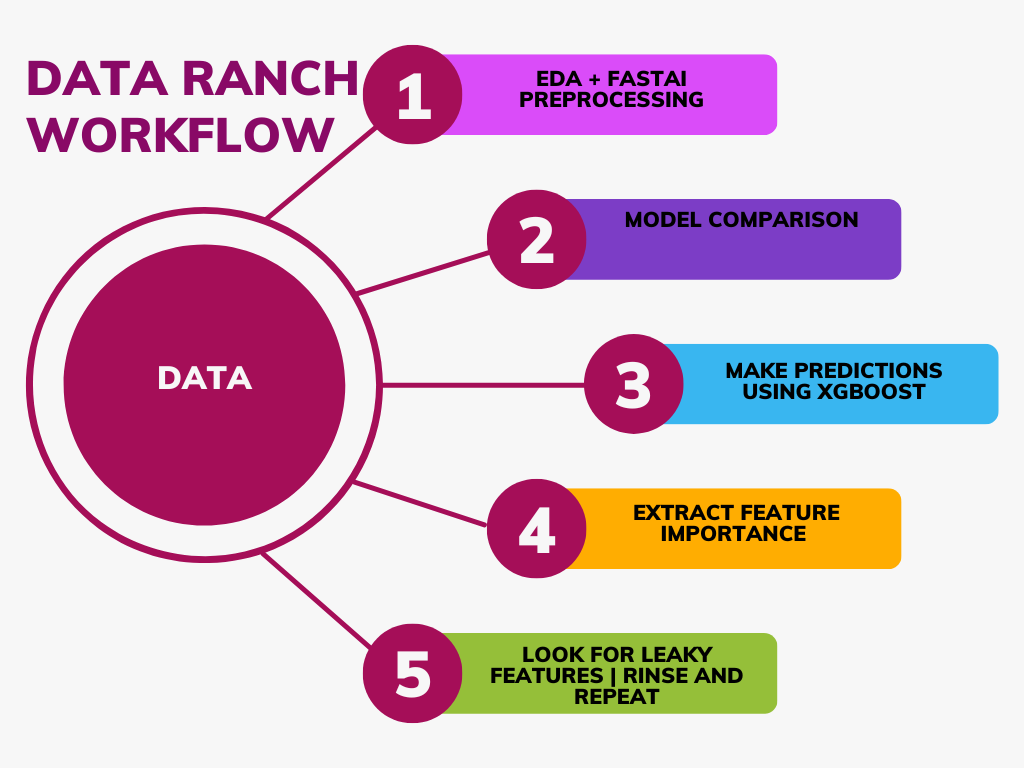

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.7 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'cpu-and-gpu-product-data'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 2000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/cpu-and-gpu-product-data
CSV!


In [12]:
df

,Unnamed: 0,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,0,AMD Athlon 64 3500+,CPU,2007-02-20,65.00,45.00,77.00,122.00,2200.00,Unknown,AMD,NaN,NaN,NaN
1,1,AMD Athlon 200GE,CPU,2018-09-06,14.00,35.00,192.00,4800.00,3200.00,Unknown,AMD,NaN,NaN,NaN
2,2,Intel Core i5-1145G7,CPU,2020-09-02,10.00,28.00,NaN,NaN,2600.00,Intel,Intel,NaN,NaN,NaN
3,3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.00,80.00,160.00,1400.00,1800.00,Intel,Intel,NaN,NaN,NaN
4,4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.00,125.00,258.00,758.00,3700.00,Unknown,AMD,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,Intel Pentium 4 HT 570,CPU,2004-06-21,90.00,115.00,109.00,125.00,3800.00,Intel,Intel,NaN,NaN,NaN
1996,1996,Intel Core i7-980X,CPU,2010-03-16,32.00,130.00,239.00,1170.00,3333.00,Intel,Intel,NaN,NaN,NaN
1997,1997,AMD EPYC 7513,CPU,2021-03-15,7.00,200.00,NaN,NaN,2600.00,TSMC,AMD,NaN,NaN,NaN
1998,1998,AMD Ryzen Threadripper 2950X,CPU,2018-08-13,12.00,180.00,213.00,19200.00,3500.00,GF,AMD,NaN,NaN,NaN


In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

,Unnamed: 0,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,0,AMD Athlon 64 3500+,CPU,2007-02-20,65.00,45.00,77.00,122.00,2200.00,Unknown,AMD,NaN,NaN,NaN
1,1,AMD Athlon 200GE,CPU,2018-09-06,14.00,35.00,192.00,4800.00,3200.00,Unknown,AMD,NaN,NaN,NaN
2,2,Intel Core i5-1145G7,CPU,2020-09-02,10.00,28.00,NaN,NaN,2600.00,Intel,Intel,NaN,NaN,NaN
3,3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.00,80.00,160.00,1400.00,1800.00,Intel,Intel,NaN,NaN,NaN
4,4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.00,125.00,258.00,758.00,3700.00,Unknown,AMD,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,Intel Pentium 4 HT 570,CPU,2004-06-21,90.00,115.00,109.00,125.00,3800.00,Intel,Intel,NaN,NaN,NaN
1996,1996,Intel Core i7-980X,CPU,2010-03-16,32.00,130.00,239.00,1170.00,3333.00,Intel,Intel,NaN,NaN,NaN
1997,1997,AMD EPYC 7513,CPU,2021-03-15,7.00,200.00,NaN,NaN,2600.00,TSMC,AMD,NaN,NaN,NaN
1998,1998,AMD Ryzen Threadripper 2950X,CPU,2018-08-13,12.00,180.00,213.00,19200.00,3500.00,GF,AMD,NaN,NaN,NaN


In [15]:
df.isna().sum()

Unnamed: 0                  0
Product                     0
Type                        0
Release Date                0
Process Size (nm)           0
TDP (W)                     0
Die Size (mm^2)           479
Transistors (million)     464
Freq (MHz)                  0
Foundry                     0
Vendor                      0
FP16 GFLOPS              2000
FP32 GFLOPS              2000
FP64 GFLOPS              2000
dtype: int64

In [16]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

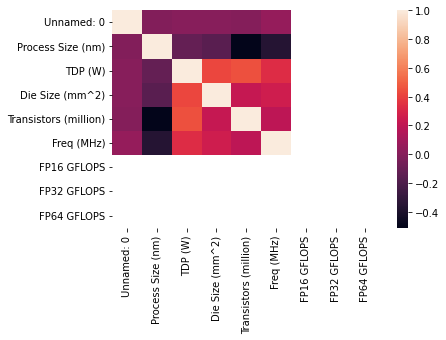

In [17]:
sns.heatmap(df.corr())

In [18]:
df.head().style.background_gradient(cmap = "inferno")

,Unnamed: 0,Product,Type,Release Date,Process Size (nm),TDP (W),Die Size (mm^2),Transistors (million),Freq (MHz),Foundry,Vendor,FP16 GFLOPS,FP32 GFLOPS,FP64 GFLOPS
0,0,AMD Athlon 64 3500+,CPU,2007-02-20,65.00,45.00,77.00,122.00,2200.00,Unknown,AMD,nan,nan,nan
1,1,AMD Athlon 200GE,CPU,2018-09-06,14.00,35.00,192.00,4800.00,3200.00,Unknown,AMD,nan,nan,nan
2,2,Intel Core i5-1145G7,CPU,2020-09-02,10.00,28.00,nan,nan,2600.00,Intel,Intel,nan,nan,nan
3,3,Intel Xeon E5-2603 v2,CPU,2013-09-01,22.00,80.00,160.00,1400.00,1800.00,Intel,Intel,nan,nan,nan
4,4,AMD Phenom II X4 980 BE,CPU,2011-05-03,45.00,125.00,258.00,758.00,3700.00,Unknown,AMD,nan,nan,nan


In [19]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2000.00,999.50,577.49,0.00,499.75,999.50,1499.25,1999.00
Process Size (nm),2000.00,52.05,41.93,7.00,14.00,32.00,90.00,180.00
TDP (W),2000.00,75.38,54.08,1.00,35.00,65.00,95.00,400.00
Die Size (mm^2),1521.00,167.24,80.30,1.00,109.00,149.00,220.00,684.00
Transistors (million),1536.00,1152.59,2033.84,37.00,114.00,410.00,1200.00,19200.00
Freq (MHz),2000.00,2487.35,754.52,600.00,2000.00,2500.00,3000.00,4700.00
FP16 GFLOPS,0.00,nan,nan,nan,nan,nan,nan,nan
FP32 GFLOPS,0.00,nan,nan,nan,nan,nan,nan,nan
FP64 GFLOPS,0.00,nan,nan,nan,nan,nan,nan,nan


In [20]:
df.columns

Index(['Unnamed: 0', 'Product', 'Type', 'Release Date', 'Process Size (nm)',
       'TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)',
       'Foundry', 'Vendor', 'FP16 GFLOPS', 'FP32 GFLOPS', 'FP64 GFLOPS'],
      dtype='object')

In [21]:
del(df['Unnamed: 0'])
del(df['Product'])
del(df['Release Date'])
del(df['FP16 GFLOPS'])
del(df['FP32 GFLOPS'])
del(df['FP64 GFLOPS'])

Target Variable: Vendor
CATS=====================
['Type', 'Process Size (nm)', 'Foundry', 'Vendor']
CONTS=====================
['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)']
8
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)']
Categorical variables that made the cut : ['Type', 'Process Size (nm)', 'Foundry', 'Vendor']
Tabular Object size: 1422


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01286172866821289}


 14%|█▍        | 6/42 [00:00<00:00, 58.65it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.024598360061645508}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03245997428894043}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009145498275756836}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.007665872573852539}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014947175979614258}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (3,4) we computed 116.18376159667969 but the user-supplied value was 116.18378448486328.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time 

 29%|██▊       | 12/42 [00:00<00:01, 23.28it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.08743071556091309}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010733366012573242}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.0253623188405796, 'RMSE': 0.039636745261872816, 'Time taken': 0.13628339767456055}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04983878135681152}


 38%|███▊      | 16/42 [00:00<00:01, 22.28it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.09304594993591309}
{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.0253623188405796, 'RMSE': 2.3396500431426973e-11, 'Time taken': 0.028977394104003906}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011744499206542969}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.0253623188405796, 'RMSE': 0.99999326, 'Time taken': 0.05803203582763672}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.017739295959472656}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02717447280883789}


 48%|████▊     | 20/42 [00:00<00:00, 22.90it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (3,4) we computed 116.18376159667969 but the user-supplied value was 116.18378448486328.
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010095357894897461}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015076875686645508}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009441614151000977}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.0253623188405796, 'RMSE': 2.4177075011713507e-12, 'Time taken': 0.00986623764038086}


 62%|██████▏   | 26/42 [00:01<00:00, 18.24it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.0253623188405796, 'RMSE': 0.086928375, 'Time taken': 0.3675251007080078}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03374338150024414}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011404037475585938}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.0253623188405796, 'RMSE': 0.04398221561195752, 'Time taken': 0.018918275833129883}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012286186218261719}


 76%|███████▌  | 32/42 [00:10<00:05,  1.68it/s]

{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.0253623188405796, 'RMSE': 9.325873406851315e-14, 'Time taken': 8.896668910980225}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.032258033752441406}


 81%|████████  | 34/42 [00:10<00:04,  1.91it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.17663812637329102}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011533737182617188}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010198593139648438}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.0253623188405796, 'RMSE': 0.00020191886724698575, 'Time taken': 0.010320425033569336}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009595870971679688}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009661436080932617}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.009535074234008789}


100%|██████████| 42/42 [00:10<00:00,  3.85it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.0253623188405796, 'RMSE': 5.9604645e-08, 'Time taken': 0.3071579933166504}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0829932689666748}
Project: cpu-and-gpu-product-data
cpu-and-gpu-product-data
Target: Vendor
Vendor
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
Lasso                                        1.00       1.00  0.00        0.03
TweedieRegressor                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
SVR                                          1.00       1.00  0.00        0.01
RidgeCV                                      1.00       1.00  0.00      

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,1.971253,0.769525,0.877226,00:00
1,1.338444,0.230149,0.479739,00:00
2,0.839871,0.109811,0.331377,00:00
3,0.546193,0.104122,0.322680,00:00
4,0.365169,0.051109,0.226074,00:00
5,0.250564,0.051773,0.227537,00:00


Better model found at epoch 0 with _rmse value: 0.8772258162498474.
Better model found at epoch 1 with _rmse value: 0.47973862290382385.
Better model found at epoch 2 with _rmse value: 0.3313771188259125.
Better model found at epoch 3 with _rmse value: 0.32267993688583374.
Better model found at epoch 4 with _rmse value: 0.22607409954071045.
No improvement since epoch 4: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: Foundry
CATS=====================
['Type', 'Process Size (nm)', 'Vendor']
CONTS=====================
['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)']
7


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 310, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)']
Categorical variables that made the cut : ['Type', 'Process Size (nm)', 'Vendor']
Tabular Object size: 1421


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype

 45%|████▌     | 19/42 [00:00<00:00, 185.52it/s]

GaussianProcessRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HistGradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HuberRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KNeighborsRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KernelRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lars model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LarsCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lasso model failed to execute
Input contains NaN, infinity or a value too large for dtype('f

 90%|█████████ | 38/42 [00:00<00:00, 172.35it/s]

SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


100%|██████████| 42/42 [00:00<00:00, 159.14it/s]

TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[18:03:28] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x16b9c9) [0x7f608a2039c9]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x178eb6) [0x7f608a210eb6]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x179d10) [0x7f608a211d10]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0xa4) [0x7f608a154754]
  [bt] (4) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f6101220a4a]
  [bt] (5) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8(+0x5fea

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost failed
Target Variable: Freq (MHz)
CATS=====================
['Type', 'Process Size (nm)', 'Vendor']
CONTS=====================
['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Foundry']
7
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Foundry']
Categorical variables that made the cut : ['Type', 'Process Size (nm)', 'Vendor', 'Foundry_na']
Tabular Object size: 1421


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 304, in <module>
    xgb.fit(X_train, y_train)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 946, in fit
    enable_categorical=self.enable_categorical,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 410, in _wrap_evaluation_matrices
    enable_categorical=enable_categorical,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 945, in <lambda>
    create_dmatrix=lambda **kwargs: DMatrix(nthread=self.n_jobs, **kwargs),
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 705, in __init__
    feature_weights=feature_weights,
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 575, in in

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5880845443594154, 'Adjusted R-Squared': 0.5761015492862347, 'RMSE': 490.4721099598092, 'Time taken': 0.06019115447998047}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7544864759523258, 'Adjusted R-Squared': 0.7473442643436661, 'RMSE': 378.658737970682, 'Time taken': 0.03715252876281738}
{'Model': 'BayesianRidge', 'R-Squared': 0.27237926334822005, 'Adjusted R-Squared': 0.2512121146456229, 'RMSE': 651.8727201308893, 'Time taken': 0.009760856628417969}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7396586609908704, 'Adjusted R-Squared': 0.7320850947651503, 'RMSE': 389.9256817538157, 'Time taken': 0.01385354995727539}
{'Model': 'DummyRegressor', 'R-Squared': -0.0006253980193029474, 'Adjusted R-Squared': -0.029734500507137218, 'RMSE': 764.44464, 'Time taken': 0.009032249450683594}
{'Model': 'ElasticNet', 'R-Squared': 0.2304194227857661, 'Adjusted R-Squared': 0.2080316241758975, 'RMSE': 670.405119721573, 'Time taken': 0.009564876556396484}


 19%|█▉        | 8/42 [00:00<00:00, 40.09it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.25272080079567816, 'Adjusted R-Squared': 0.23098176954609795, 'RMSE': 660.6200034098931, 'Time taken': 0.05499768257141113}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7313292264985678, 'Adjusted R-Squared': 0.7235133494512533, 'RMSE': 396.1142679444769, 'Time taken': 0.012936830520629883}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7544232921037908, 'Adjusted R-Squared': 0.7472792424195374, 'RMSE': 378.7074594766196, 'Time taken': 0.17325401306152344}
{'Model': 'GammaRegressor', 'R-Squared': 0.19326184240825117, 'Adjusted R-Squared': 0.16979309600558212, 'RMSE': 686.398889991249, 'Time taken': 0.011955499649047852}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4999.731027419927, 'Adjusted R-Squared': -5145.2068391266885, 'RMSE': 54041.45346402177, 'Time taken': 0.19347310066223145}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7283493930045024, 'Adjusted R-Squared': 0.7204468298919061, 'RMSE': 398.30486675396406, 'Time take

 43%|████▎     | 18/42 [00:01<00:01, 15.15it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7513987973217888, 'Adjusted R-Squared': 0.7441667623347863, 'RMSE': 381.03238199459145, 'Time taken': 0.3676433563232422}
{'Model': 'HuberRegressor', 'R-Squared': 0.26021951505311147, 'Adjusted R-Squared': 0.2386986282182929, 'RMSE': 657.2970881913852, 'Time taken': 0.013814687728881836}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6865662102718971, 'Adjusted R-Squared': 0.6774481363888978, 'RMSE': 427.84177, 'Time taken': 0.010570049285888672}
{'Model': 'KernelRidge', 'R-Squared': -10.10247215759154, 'Adjusted R-Squared': -10.425453165812385, 'RMSE': 2546.361852478074, 'Time taken': 0.04875683784484863}
{'Model': 'Lars', 'R-Squared': 0.2725784059032159, 'Adjusted R-Squared': 0.2514170504385822, 'RMSE': 651.7835084880618, 'Time taken': 0.014432668685913086}
{'Model': 'LarsCV', 'R-Squared': 0.2725784059032159, 'Adjusted R-Squared': 0.2514170504385822, 'RMSE': 651.7835084880618, 'Time taken': 0.01996326446533203}
{'Model': 'Las

 52%|█████▏    | 22/42 [00:01<00:01, 17.98it/s]

{'Model': 'LassoCV', 'R-Squared': 0.272386770694412, 'Adjusted R-Squared': 0.25121984038734035, 'RMSE': 651.869357220406, 'Time taken': 0.0945289134979248}
{'Model': 'LassoLars', 'R-Squared': 0.2505872131346669, 'Adjusted R-Squared': 0.2287861138804027, 'RMSE': 661.5624129198376, 'Time taken': 0.010792016983032227}
{'Model': 'LassoLarsCV', 'R-Squared': 0.2725784059032159, 'Adjusted R-Squared': 0.2514170504385822, 'RMSE': 651.7835084880618, 'Time taken': 0.015268564224243164}
{'Model': 'LassoLarsIC', 'R-Squared': 0.2725784059032159, 'Adjusted R-Squared': 0.2514170504385822, 'RMSE': 651.7835084880618, 'Time taken': 0.012466669082641602}
{'Model': 'LinearRegression', 'R-Squared': 0.272578405903216, 'Adjusted R-Squared': 0.2514170504385823, 'RMSE': 651.7835084880618, 'Time taken': 0.008465290069580078}
{'Model': 'LinearSVR', 'R-Squared': -3.3709915324391373, 'Adjusted R-Squared': -3.498147649746458, 'RMSE': 1597.7184694907992, 'Time taken': 0.008465290069580078}


 69%|██████▉   | 29/42 [00:02<00:01,  9.59it/s]

{'Model': 'MLPRegressor', 'R-Squared': -7.944571689492653, 'Adjusted R-Squared': -8.204777411368802, 'RMSE': 2285.546426935084, 'Time taken': 1.0646822452545166}
{'Model': 'NuSVR', 'R-Squared': 0.07247720018290782, 'Adjusted R-Squared': 0.04549471873368338, 'RMSE': 735.9911125294569, 'Time taken': 0.10706067085266113}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.1718636733104154, 'Adjusted R-Squared': 0.14777243471580936, 'RMSE': 695.442440802449, 'Time taken': 0.011904716491699219}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.2725784059032159, 'Adjusted R-Squared': 0.2514170504385822, 'RMSE': 651.7835084880618, 'Time taken': 0.012862443923950195}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.22666983736123392, 'Adjusted R-Squared': 0.2041729599026516, 'RMSE': 672.0363243577115, 'Time taken': 0.010827779769897461}
{'Model': 'PoissonRegressor', 'R-Squared': 0.23385040666315549, 'Adjusted R-Squared': 0.21156241849335644, 'RMSE': 668.9090330109008, 'Time taken

 76%|███████▌  | 32/42 [00:20<00:16,  1.63s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.014006695998837415, 'Adjusted R-Squared': -0.04350507260971259, 'RMSE': 769.5390883242534, 'Time taken': 17.59074878692627}
{'Model': 'RANSACRegressor', 'R-Squared': -0.9005502594267227, 'Adjusted R-Squared': -0.9558389942464092, 'RMSE': 1053.5373879804054, 'Time taken': 0.0703885555267334}


 90%|█████████ | 38/42 [00:20<00:03,  1.16it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7623842524401263, 'Adjusted R-Squared': 0.7554717943292937, 'RMSE': 372.51853189756423, 'Time taken': 0.2707061767578125}
{'Model': 'Ridge', 'R-Squared': 0.27256599874012244, 'Adjusted R-Squared': 0.25140428233983514, 'RMSE': 651.789066990775, 'Time taken': 0.011904478073120117}
{'Model': 'RidgeCV', 'R-Squared': 0.27241962103249107, 'Adjusted R-Squared': 0.25125364637161807, 'RMSE': 651.8546417303538, 'Time taken': 0.008081197738647461}
{'Model': 'SGDRegressor', 'R-Squared': 0.27423245518835837, 'Adjusted R-Squared': 0.25311921752111066, 'RMSE': 651.0420570363619, 'Time taken': 0.00937342643737793}
{'Model': 'SVR', 'R-Squared': 0.08570035717992897, 'Adjusted R-Squared': 0.05910254938879966, 'RMSE': 730.7259795141732, 'Time taken': 0.08980393409729004}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.272578405903216, 'Adjusted R-Squared': 0.2514170504385823, 'RMSE': 651.7835084880618, 'Time taken': 0.011159181594848633}
{'Model': '

100%|██████████| 42/42 [00:21<00:00,  2.00it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.761706973748651, 'Adjusted R-Squared': 0.7547748129849754, 'RMSE': 373.04907, 'Time taken': 0.32284116744995117}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7597243165229516, 'Adjusted R-Squared': 0.7527344784581647, 'RMSE': 374.5977665723889, 'Time taken': 0.08361625671386719}
Project: cpu-and-gpu-product-data
cpu-and-gpu-product-data
Target: Freq (MHz)
Freq (MHz)
Target Standard Deviation: 754.5678100585938
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
RandomForestRegressor                        0.76       0.76   372.52   
XGBRegressor                                 0.75       0.76   373.05   
LGBMRegressor                                0.75       0.76   374.60   
BaggingRegressor                             0.75       0.75   378.66   
ExtraTreesRegressor                          0.75       0.75   378.71   
HistGradientBoostingRegressor        

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0 1800.00    1754.24
1 3400.00    3389.69
2 2200.00    2553.41
3 2800.00    2199.62
4 2500.00    3042.02
XGBoost RMSE:  373.41885


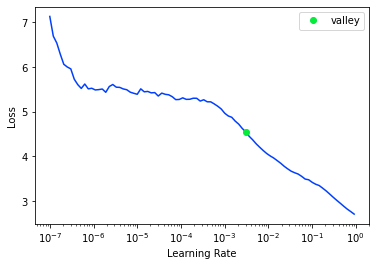

<Figure size 720x720 with 0 Axes>

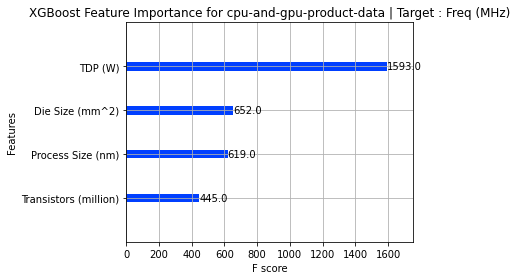

Target Variable: Transistors (million)
CATS=====================
['Type', 'Process Size (nm)', 'Vendor']
CONTS=====================
['TDP (W)', 'Die Size (mm^2)', 'Freq (MHz)', 'Foundry']
7
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['TDP (W)', 'Die Size (mm^2)', 'Freq (MHz)', 'Foundry']
Categorical variables that made the cut : ['Type', 'Process Size (nm)', 'Vendor', 'Foundry_na']
Tabular Object size: 1421


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5573928774539606, 'Adjusted R-Squared': 0.5445170338889849, 'RMSE': 1124.0387547717735, 'Time taken': 0.03328227996826172}


 14%|█▍        | 6/42 [00:00<00:00, 56.05it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.8241879602314411, 'Adjusted R-Squared': 0.8190734281654467, 'RMSE': 708.4290999256863, 'Time taken': 0.03693819046020508}
{'Model': 'BayesianRidge', 'R-Squared': 0.28498697934416284, 'Adjusted R-Squared': 0.2641866005614476, 'RMSE': 1428.660578339466, 'Time taken': 0.009345054626464844}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8138280052358362, 'Adjusted R-Squared': 0.8084120926608787, 'RMSE': 729.0029101161027, 'Time taken': 0.010033607482910156}
{'Model': 'DummyRegressor', 'R-Squared': -0.005753057131491879, 'Adjusted R-Squared': -0.03501132788440797, 'RMSE': 1694.4071, 'Time taken': 0.00811314582824707}
{'Model': 'ElasticNet', 'R-Squared': 0.2674344581686039, 'Adjusted R-Squared': 0.24612346058805423, 'RMSE': 1446.0900211758058, 'Time taken': 0.008944034576416016}
{'Model': 'ElasticNetCV', 'R-Squared': 0.24804617510161553, 'Adjusted R-Squared': 0.2261711547409353, 'RMSE': 1465.1013628194617, 'Time taken': 0.05824542045593262}
{'M

 29%|██▊       | 12/42 [00:00<00:01, 17.77it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.863494084654394, 'Adjusted R-Squared': 0.8595230034807037, 'RMSE': 624.2345779752249, 'Time taken': 0.14842462539672852}


 48%|████▊     | 20/42 [00:01<00:01, 17.31it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6706567877687635, 'Adjusted R-Squared': 0.6610758943220366, 'RMSE': 969.6085679278652, 'Time taken': 0.3135709762573242}
{'Model': 'HuberRegressor', 'R-Squared': 0.2548738059466884, 'Adjusted R-Squared': 0.23319740757422847, 'RMSE': 1458.4347421883863, 'Time taken': 0.014230966567993164}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.76412325794567, 'Adjusted R-Squared': 0.7572613890859077, 'RMSE': 820.5681, 'Time taken': 0.009957313537597656}
{'Model': 'KernelRidge', 'R-Squared': 0.06794938059654143, 'Adjusted R-Squared': 0.04083518075934989, 'RMSE': 1631.1422449136571, 'Time taken': 0.04134631156921387}
{'Model': 'Lars', 'R-Squared': 0.2842037021948183, 'Adjusted R-Squared': 0.26338053716775844, 'RMSE': 1429.442893382674, 'Time taken': 0.018765926361083984}
{'Model': 'LarsCV', 'R-Squared': 0.2842037021948183, 'Adjusted R-Squared': 0.26338053716775844, 'RMSE': 1429.442893382674, 'Time taken': 0.04024171829223633}
{'Model': 'La

 67%|██████▋   | 28/42 [00:02<00:01,  9.99it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.11158477784983489, 'Adjusted R-Squared': 0.08573997138728462, 'RMSE': 1592.5023487089554, 'Time taken': 1.0135982036590576}
{'Model': 'NuSVR', 'R-Squared': 0.0007416897027484604, 'Adjusted R-Squared': -0.02832764296044421, 'RMSE': 1688.9273567120572, 'Time taken': 0.10649561882019043}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.11248668203690304, 'Adjusted R-Squared': 0.08666811278706754, 'RMSE': 1591.693802654972, 'Time taken': 0.011209964752197266}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.2842037021948183, 'Adjusted R-Squared': 0.26338053716775844, 'RMSE': 1429.442893382674, 'Time taken': 0.01398158073425293}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.2529161039009207, 'Adjusted R-Squared': 0.23118275419622025, 'RMSE': 1460.3493895166337, 'Time taken': 0.010297775268554688}
{'Model': 'PoissonRegressor', 'R-Squared': 0.40522803476868263, 'Adjusted R-Squared': 0.38792557759831703, 'RMSE': 1303.008746098459, '

 79%|███████▊  | 33/42 [00:29<00:18,  2.02s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.13341045607636048, 'Adjusted R-Squared': -0.16638239661676368, 'RMSE': 1798.7288208183584, 'Time taken': 26.90533995628357}
{'Model': 'RANSACRegressor', 'R-Squared': -0.11422530057158542, 'Adjusted R-Squared': -0.14663912749730423, 'RMSE': 1783.4403728007755, 'Time taken': 0.1147909164428711}


 90%|█████████ | 38/42 [00:29<00:04,  1.08s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8526588584464676, 'Adjusted R-Squared': 0.848372570692183, 'RMSE': 648.5360186413005, 'Time taken': 0.24940156936645508}
{'Model': 'Ridge', 'R-Squared': 0.28431399732923346, 'Adjusted R-Squared': 0.26349404088790207, 'RMSE': 1429.3327596264708, 'Time taken': 0.009521722793579102}
{'Model': 'RidgeCV', 'R-Squared': 0.2852485078545858, 'Adjusted R-Squared': 0.26445573717399196, 'RMSE': 1428.3992756538264, 'Time taken': 0.010877609252929688}
{'Model': 'SGDRegressor', 'R-Squared': 0.28685656603511667, 'Adjusted R-Squared': 0.2661105752288655, 'RMSE': 1426.791554265219, 'Time taken': 0.010466337203979492}
{'Model': 'SVR', 'R-Squared': -0.08664968509398241, 'Adjusted R-Squared': -0.11826131229671644, 'RMSE': 1761.2332068411386, 'Time taken': 0.08760690689086914}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.2842037021948183, 'Adjusted R-Squared': 0.26338053716775844, 'RMSE': 1429.442893382674, 'Time taken': 0.01222372055053711}
{'Mode

100%|██████████| 42/42 [00:30<00:00,  1.39it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8443017431159048, 'Adjusted R-Squared': 0.8397723392792765, 'RMSE': 666.6747, 'Time taken': 0.3189125061035156}
{'Model': 'LGBMRegressor', 'R-Squared': 0.688811231864743, 'Adjusted R-Squared': 0.6797584677008083, 'RMSE': 942.5058243312137, 'Time taken': 0.086761474609375}
Project: cpu-and-gpu-product-data
cpu-and-gpu-product-data
Target: Transistors (million)
Transistors (million)
Target Standard Deviation: 1819.9580078125
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
ExtraTreesRegressor                          0.88       0.88   583.88   
GradientBoostingRegressor                    0.86       0.86   624.23   
RandomForestRegressor                        0.85       0.85   648.54   
XGBRegressor                                 0.84       0.84   666.67   
BaggingRegressor                             0.82       0.82   708.43   
DecisionTreeRegressor

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0 1160.00    1154.23
1  228.00     229.15
2 1400.00    1410.88
3 1178.00    1206.69
4 1400.00    1367.75
XGBoost RMSE:  666.7469


<Figure size 432x288 with 0 Axes>

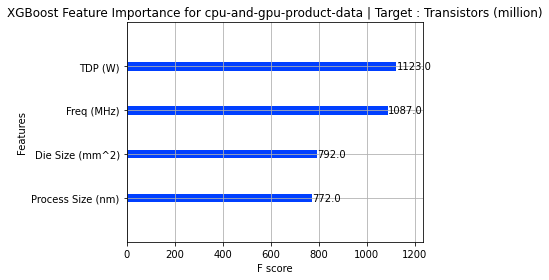

Target Variable: Die Size (mm^2)
CATS=====================
['Type', 'Process Size (nm)', 'Vendor']
CONTS=====================
['TDP (W)', 'Transistors (million)', 'Freq (MHz)', 'Foundry']
7
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['TDP (W)', 'Transistors (million)', 'Freq (MHz)', 'Foundry']
Categorical variables that made the cut : ['Type', 'Process Size (nm)', 'Vendor', 'Foundry_na']
Tabular Object size: 1421


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6344726265264735, 'Adjusted R-Squared': 0.6238391029345164, 'RMSE': 61.14248035407431, 'Time taken': 0.04025888442993164}


 12%|█▏        | 5/42 [00:00<00:00, 46.39it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.8079821248562828, 'Adjusted R-Squared': 0.8023961503066475, 'RMSE': 44.315324067003466, 'Time taken': 0.03658795356750488}
{'Model': 'BayesianRidge', 'R-Squared': 0.10883759312831087, 'Adjusted R-Squared': 0.08291286856477087, 'RMSE': 95.46881427985332, 'Time taken': 0.011516571044921875}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7548834335446326, 'Adjusted R-Squared': 0.7477527697932038, 'RMSE': 50.06905931124519, 'Time taken': 0.01080012321472168}
{'Model': 'DummyRegressor', 'R-Squared': -5.564233904964411e-06, 'Adjusted R-Squared': -0.02909663519343675, 'RMSE': 101.131, 'Time taken': 0.008247137069702148}
{'Model': 'ElasticNet', 'R-Squared': 0.09734048219627012, 'Adjusted R-Squared': 0.071081296223798, 'RMSE': 96.08267435735826, 'Time taken': 0.009783267974853516}
{'Model': 'ElasticNetCV', 'R-Squared': 0.1109865536391732, 'Adjusted R-Squared': 0.08512434429049465, 'RMSE': 95.35363743876279, 'Time taken': 0.04929709434509277}
{'Mod

 24%|██▍       | 10/42 [00:00<00:01, 27.58it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8220291554907221, 'Adjusted R-Squared': 0.8168518218322703, 'RMSE': 42.66360309708208, 'Time taken': 0.15774869918823242}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -23490.938679473387, 'Adjusted R-Squared': -24174.34053196716, 'RMSE': 15500.386559879084, 'Time taken': 0.11832404136657715}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7934393287000987, 'Adjusted R-Squared': 0.7874302909895561, 'RMSE': 45.962846610938854, 'Time taken': 0.12671422958374023}


 40%|████      | 17/42 [00:01<00:01, 14.82it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7951454800891415, 'Adjusted R-Squared': 0.7891860758735529, 'RMSE': 45.77263087678648, 'Time taken': 0.3337998390197754}
{'Model': 'HuberRegressor', 'R-Squared': 0.07261173163250279, 'Adjusted R-Squared': 0.04563316382544835, 'RMSE': 97.38989523009698, 'Time taken': 0.012856006622314453}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6507425910075737, 'Adjusted R-Squared': 0.6405823754732486, 'RMSE': 59.76624, 'Time taken': 0.011866092681884766}
{'Model': 'KernelRidge', 'R-Squared': -1.528639852437892, 'Adjusted R-Squared': -1.6022002845088124, 'RMSE': 160.8150125445672, 'Time taken': 0.06646251678466797}
{'Model': 'Lars', 'R-Squared': 0.10790150471133753, 'Adjusted R-Squared': 0.08194954848475833, 'RMSE': 95.51894195284062, 'Time taken': 0.025935888290405273}
{'Model': 'LarsCV', 'R-Squared': 0.11151095703912894, 'Adjusted R-Squared': 0.08566400306208544, 'RMSE': 95.32551010953217, 'Time taken': 0.03681468963623047}
{'Model': '

 48%|████▊     | 20/42 [00:01<00:01, 16.67it/s]

{'Model': 'LassoCV', 'R-Squared': 0.11135865199633688, 'Adjusted R-Squared': 0.08550726732713942, 'RMSE': 95.33368012235958, 'Time taken': 0.061279296875}
{'Model': 'LassoLars', 'R-Squared': -5.587518978833472e-06, 'Adjusted R-Squared': -0.029096659155894544, 'RMSE': 101.13100266825171, 'Time taken': 0.008720159530639648}
{'Model': 'LassoLarsCV', 'R-Squared': 0.11151095703912894, 'Adjusted R-Squared': 0.08566400306208544, 'RMSE': 95.32551010953217, 'Time taken': 0.014874935150146484}
{'Model': 'LassoLarsIC', 'R-Squared': 0.10790150471133753, 'Adjusted R-Squared': 0.08194954848475833, 'RMSE': 95.51894195284062, 'Time taken': 0.009659290313720703}
{'Model': 'LinearRegression', 'R-Squared': 0.10790150471133764, 'Adjusted R-Squared': 0.08194954848475844, 'RMSE': 95.5189419528406, 'Time taken': 0.008547067642211914}
{'Model': 'LinearSVR', 'R-Squared': 0.04109165973039619, 'Adjusted R-Squared': 0.013196144377098706, 'RMSE': 99.03111019891067, 'Time taken': 0.008584260940551758}


 67%|██████▋   | 28/42 [00:02<00:01,  9.11it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.025407970972901373, 'Adjusted R-Squared': -0.002943797144250526, 'RMSE': 99.83769077542387, 'Time taken': 1.0921573638916016}
{'Model': 'NuSVR', 'R-Squared': 0.2048152355299574, 'Adjusted R-Squared': 0.18168258783628344, 'RMSE': 90.1814315441324, 'Time taken': 0.11004424095153809}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.03077074351634479, 'Adjusted R-Squared': 0.00257498332772943, 'RMSE': 99.56262932698318, 'Time taken': 0.01146078109741211}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.1095695309521848, 'Adjusted R-Squared': 0.08366609912533929, 'RMSE': 95.42960055764955, 'Time taken': 0.014934301376342773}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.015416201327447698, 'Adjusted R-Squared': -0.013226236452117401, 'RMSE': 100.34816664794191, 'Time taken': 0.012079477310180664}
{'Model': 'PoissonRegressor', 'R-Squared': -0.06546802290876674, 'Adjusted R-Squared': -0.09646345630247621, 'RMSE': 104.38865689758403

 76%|███████▌  | 32/42 [00:18<00:14,  1.47s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.006390571808013723, 'Adjusted R-Squared': -0.03566738844242856, 'RMSE': 101.45334707645408, 'Time taken': 16.38452935218811}
{'Model': 'RANSACRegressor', 'R-Squared': -3.8178092728788293, 'Adjusted R-Squared': -3.957963724453486, 'RMSE': 221.9769610162569, 'Time taken': 0.06182599067687988}


 90%|█████████ | 38/42 [00:19<00:03,  1.27it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8270908977500511, 'Adjusted R-Squared': 0.8220608147755071, 'RMSE': 42.05252016557233, 'Time taken': 0.24424386024475098}
{'Model': 'Ridge', 'R-Squared': 0.10798573275852419, 'Adjusted R-Squared': 0.08203622680240852, 'RMSE': 95.51443260555232, 'Time taken': 0.01047062873840332}
{'Model': 'RidgeCV', 'R-Squared': 0.1086961124807947, 'Adjusted R-Squared': 0.08276727211659962, 'RMSE': 95.47639227770703, 'Time taken': 0.009147405624389648}
{'Model': 'SGDRegressor', 'R-Squared': 0.10737793398209428, 'Adjusted R-Squared': 0.08141074660702796, 'RMSE': 95.54696777436432, 'Time taken': 0.009650468826293945}
{'Model': 'SVR', 'R-Squared': 0.2312961494951521, 'Adjusted R-Squared': 0.20893385566228384, 'RMSE': 88.66712524149256, 'Time taken': 0.08778524398803711}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.10790150471133764, 'Adjusted R-Squared': 0.08194954848475844, 'RMSE': 95.5189419528406, 'Time taken': 0.012035369873046875}
{'Model': 

100%|██████████| 42/42 [00:19<00:00,  2.13it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8054400816520442, 'Adjusted R-Squared': 0.7997801567546491, 'RMSE': 44.607697, 'Time taken': 0.3274099826812744}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7973945921316137, 'Adjusted R-Squared': 0.7915006166299879, 'RMSE': 45.520666934384494, 'Time taken': 0.08675789833068848}
Project: cpu-and-gpu-product-data
cpu-and-gpu-product-data
Target: Die Size (mm^2)
Die Size (mm^2)
Target Standard Deviation: 99.48526763916016
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
RandomForestRegressor                        0.82       0.83    42.05   
ExtraTreesRegressor                          0.82       0.82    42.66   
BaggingRegressor                             0.80       0.81    44.32   
XGBRegressor                                 0.80       0.81    44.61   
LGBMRegressor                                0.79       0.80    45.52   
HistGradientBoostingRegres

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0  228.00     237.86
1    0.00      21.31
2    0.00       0.47
3   74.00      74.17
4   84.00      85.88
XGBoost RMSE:  44.60223


<Figure size 432x288 with 0 Axes>

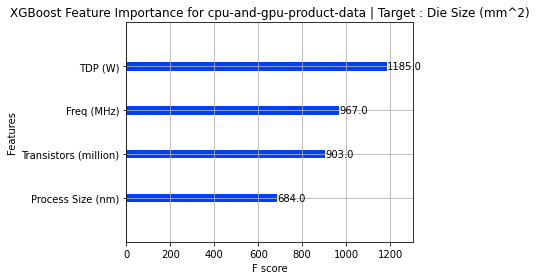

Target Variable: TDP (W)
CATS=====================
['Type', 'Process Size (nm)', 'Vendor']
CONTS=====================
['Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)', 'Foundry']
7
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)', 'Foundry']
Categorical variables that made the cut : ['Type', 'Process Size (nm)', 'Vendor', 'Foundry_na']
Tabular Object size: 1421


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5266558281587813, 'Adjusted R-Squared': 0.5128858158870369, 'RMSE': 40.307649011015066, 'Time taken': 0.02778792381286621}


 12%|█▏        | 5/42 [00:00<00:00, 47.81it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.6672322349733246, 'Adjusted R-Squared': 0.6575517181725486, 'RMSE': 33.79633264328116, 'Time taken': 0.04342174530029297}
{'Model': 'BayesianRidge', 'R-Squared': 0.24069978707851336, 'Adjusted R-Squared': 0.21861105361170652, 'RMSE': 51.05117142982083, 'Time taken': 0.010917901992797852}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.6320445490079578, 'Adjusted R-Squared': 0.6213403904336439, 'RMSE': 35.53829365520125, 'Time taken': 0.01296234130859375}
{'Model': 'DummyRegressor', 'R-Squared': -0.0006114183707490728, 'Adjusted R-Squared': -0.029720114177897994, 'RMSE': 58.604595, 'Time taken': 0.009146928787231445}
{'Model': 'ElasticNet', 'R-Squared': 0.21103290214858472, 'Adjusted R-Squared': 0.1880811320292709, 'RMSE': 52.03893467666057, 'Time taken': 0.012547969818115234}
{'Model': 'ElasticNetCV', 'R-Squared': 0.24037507384031842, 'Adjusted R-Squared': 0.21827689417021867, 'RMSE': 51.06208622939945, 'Time taken': 0.05203127861022949}
{

 24%|██▍       | 10/42 [00:00<00:01, 24.49it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.6395602057297496, 'Adjusted R-Squared': 0.6290746844418877, 'RMSE': 35.17347829347617, 'Time taken': 0.18773627281188965}
{'Model': 'GammaRegressor', 'R-Squared': 0.16912660105978905, 'Adjusted R-Squared': 0.14495573854516475, 'RMSE': 53.40308898456176, 'Time taken': 0.011140584945678711}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -150.15205472325133, 'Adjusted R-Squared': -154.54920540610954, 'RMSE': 720.2876670381277, 'Time taken': 0.118804931640625}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7573448094237233, 'Adjusted R-Squared': 0.7502857493342316, 'RMSE': 28.859828364691822, 'Time taken': 0.11507153511047363}


 40%|████      | 17/42 [00:01<00:01, 14.33it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.715924931019285, 'Adjusted R-Squared': 0.7076609290125733, 'RMSE': 31.22593932605824, 'Time taken': 0.35636138916015625}
{'Model': 'HuberRegressor', 'R-Squared': 0.1950033707521196, 'Adjusted R-Squared': 0.17158528699218134, 'RMSE': 52.56491688357302, 'Time taken': 0.014812707901000977}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.688278522690305, 'Adjusted R-Squared': 0.6792102615322048, 'RMSE': 32.710133, 'Time taken': 0.011818170547485352}
{'Model': 'KernelRidge', 'R-Squared': -1.5536969355200294, 'Adjusted R-Squared': -1.6279863009169757, 'RMSE': 93.62323184710273, 'Time taken': 0.06182384490966797}
{'Model': 'Lars', 'R-Squared': 0.24102964963695084, 'Adjusted R-Squared': 0.21895051217184403, 'RMSE': 51.04008115283636, 'Time taken': 0.025682687759399414}
{'Model': 'LarsCV', 'R-Squared': 0.2431996193052468, 'Adjusted R-Squared': 0.22118360823049033, 'RMSE': 50.96706465989281, 'Time taken': 0.04098653793334961}
{'Model': 'L

 48%|████▊     | 20/42 [00:01<00:01, 16.23it/s]

{'Model': 'LassoCV', 'R-Squared': 0.24331463534884457, 'Adjusted R-Squared': 0.22130197019535647, 'RMSE': 50.96319160894009, 'Time taken': 0.06014084815979004}
{'Model': 'LassoLars', 'R-Squared': -0.0006113873188475782, 'Adjusted R-Squared': -0.029720082222668642, 'RMSE': 58.60459535197876, 'Time taken': 0.010391473770141602}
{'Model': 'LassoLarsCV', 'R-Squared': 0.2431996193052468, 'Adjusted R-Squared': 0.22118360823049033, 'RMSE': 50.96706465989281, 'Time taken': 0.016986846923828125}
{'Model': 'LassoLarsIC', 'R-Squared': 0.24102964963695084, 'Adjusted R-Squared': 0.21895051217184403, 'RMSE': 51.04008115283636, 'Time taken': 0.011934757232666016}
{'Model': 'LinearRegression', 'R-Squared': 0.24102964963695084, 'Adjusted R-Squared': 0.21895051217184403, 'RMSE': 51.04008115283636, 'Time taken': 0.009668827056884766}
{'Model': 'LinearSVR', 'R-Squared': 0.10034010765395696, 'Adjusted R-Squared': 0.07416818351298116, 'RMSE': 55.569710075797204, 'Time taken': 0.009914636611938477}


 67%|██████▋   | 28/42 [00:02<00:01,  9.50it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.40244444517671774, 'Adjusted R-Squared': 0.3850610108545859, 'RMSE': 45.288516519078364, 'Time taken': 1.0129330158233643}
{'Model': 'NuSVR', 'R-Squared': 0.28846138760323536, 'Adjusted R-Squared': 0.2677620825153295, 'RMSE': 49.4194818199164, 'Time taken': 0.10138773918151855}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.08696825286110832, 'Adjusted R-Squared': 0.06040732930797699, 'RMSE': 55.98115962751889, 'Time taken': 0.011106252670288086}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.25017984785839, 'Adjusted R-Squared': 0.22836689797790677, 'RMSE': 50.731476846902744, 'Time taken': 0.014426231384277344}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.11888354562036918, 'Adjusted R-Squared': 0.09325106694750718, 'RMSE': 54.994037677961636, 'Time taken': 0.00989079475402832}
{'Model': 'PoissonRegressor', 'R-Squared': 0.17410976193152405, 'Adjusted R-Squared': 0.15008386409680474, 'RMSE': 53.242705710412594, 'Time t

 76%|███████▌  | 32/42 [00:20<00:15,  1.59s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04259572323576144, 'Adjusted R-Squared': -0.07292578063898358, 'RMSE': 59.82144794243936, 'Time taken': 17.84257173538208}
{'Model': 'RANSACRegressor', 'R-Squared': -0.16907242281943713, 'Adjusted R-Squared': -0.20308180239236617, 'RMSE': 63.34606749038724, 'Time taken': 0.05898785591125488}


 90%|█████████ | 38/42 [00:20<00:03,  1.17it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6907248448545508, 'Adjusted R-Squared': 0.6817277494321377, 'RMSE': 32.581529496371566, 'Time taken': 0.28320932388305664}
{'Model': 'Ridge', 'R-Squared': 0.2410097186203538, 'Adjusted R-Squared': 0.21893000134385499, 'RMSE': 51.040751320007956, 'Time taken': 0.010578155517578125}
{'Model': 'RidgeCV', 'R-Squared': 0.2408157217301815, 'Adjusted R-Squared': 0.21873036090778686, 'RMSE': 51.04727387677423, 'Time taken': 0.009583711624145508}
{'Model': 'SGDRegressor', 'R-Squared': 0.2478650284656584, 'Adjusted R-Squared': 0.22598473838465938, 'RMSE': 50.80972475141565, 'Time taken': 0.010226249694824219}
{'Model': 'SVR', 'R-Squared': 0.26226081298629633, 'Adjusted R-Squared': 0.24079930936407956, 'RMSE': 50.321129135892626, 'Time taken': 0.08912539482116699}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.24102964963695084, 'Adjusted R-Squared': 0.21895051217184403, 'RMSE': 51.04008115283636, 'Time taken': 0.01125788688659668}
{'Model

100%|██████████| 42/42 [00:21<00:00,  1.98it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.680946045935847, 'Adjusted R-Squared': 0.6716644763630716, 'RMSE': 33.09261, 'Time taken': 0.33679723739624023}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7222539960842261, 'Adjusted R-Squared': 0.7141741123339491, 'RMSE': 30.876129994214182, 'Time taken': 0.08829045295715332}
Project: cpu-and-gpu-product-data
cpu-and-gpu-product-data
Target: TDP (W)
TDP (W)
Target Standard Deviation: 55.39469909667969
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
GradientBoostingRegressor                    0.75       0.76  28.86   
LGBMRegressor                                0.71       0.72  30.88   
HistGradientBoostingRegressor                0.71       0.72  31.23   
RandomForestRegressor                        0.68       0.69  32.58   
KNeighborsRegressor                          0.68       0.69  32.71   
XGBRegressor                                 0.67       0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0   95.00     118.47
1   89.00      87.56
2  115.00     110.42
3   95.00     120.25
4  320.00     258.58
XGBoost RMSE:  32.99399


<Figure size 432x288 with 0 Axes>

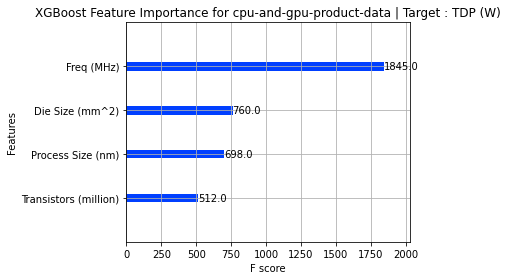

Target Variable: Process Size (nm)
CATS=====================
['Type', 'Process Size (nm)', 'Vendor']
CONTS=====================
['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)', 'Foundry']
8
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['TDP (W)', 'Die Size (mm^2)', 'Transistors (million)', 'Freq (MHz)', 'Foundry']
Categorical variables that made the cut : ['Type', 'Process Size (nm)', 'Vendor', 'Foundry_na']
Tabular Object size: 1421


 12%|█▏        | 5/42 [00:00<00:00, 46.77it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8236921600415297, 'Adjusted R-Squared': 0.8185632046972833, 'RMSE': 1.3212768233077292, 'Time taken': 0.04193305969238281}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9296574125109718, 'Adjusted R-Squared': 0.9276110826931091, 'RMSE': 0.8345784653276961, 'Time taken': 0.03384256362915039}
{'Model': 'BayesianRidge', 'R-Squared': 0.2872413172450423, 'Adjusted R-Squared': 0.2665065192012618, 'RMSE': 2.6566189302272396, 'Time taken': 0.010279655456542969}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8763389900118075, 'Adjusted R-Squared': 0.872741578812151, 'RMSE': 1.1065585528953792, 'Time taken': 0.011113643646240234}
{'Model': 'DummyRegressor', 'R-Squared': -0.005433484341403005, 'Adjusted R-Squared': -0.03468245843133477, 'RMSE': 3.1552565502621994, 'Time taken': 0.009447813034057617}
{'Model': 'ElasticNet', 'R-Squared': 0.16889475786565755, 'Adjusted R-Squared': 0.1447171508217494, 'RMSE': 2.8687058265177914, 'Time taken': 0.01000618

 24%|██▍       | 10/42 [00:00<00:01, 27.05it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9412819563935325, 'Adjusted R-Squared': 0.9395737951249807, 'RMSE': 0.7625069267752796, 'Time taken': 0.15689587593078613}
{'Model': 'GammaRegressor', 'R-Squared': 0.23151173586695506, 'Adjusted R-Squared': 0.2091557136376302, 'RMSE': 2.7585230961224516, 'Time taken': 0.011286735534667969}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -8053.602030970288, 'Adjusted R-Squared': -8287.917726416696, 'RMSE': 282.40998538300926, 'Time taken': 0.11560273170471191}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9188090379011269, 'Adjusted R-Squared': 0.9164471190037051, 'RMSE': 0.896627074311801, 'Time taken': 0.15958285331726074}


 43%|████▎     | 18/42 [00:01<00:01, 16.05it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9401638486652998, 'Adjusted R-Squared': 0.9384231606264721, 'RMSE': 0.7697325119045881, 'Time taken': 0.30863094329833984}
{'Model': 'HuberRegressor', 'R-Squared': 0.26032602548667105, 'Adjusted R-Squared': 0.23880823713719246, 'RMSE': 2.7063139354808983, 'Time taken': 0.013889551162719727}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7802941239076784, 'Adjusted R-Squared': 0.7739026802395381, 'RMSE': 1.4749552392348992, 'Time taken': 0.010935544967651367}
{'Model': 'KernelRidge', 'R-Squared': -5.556924672132576, 'Adjusted R-Squared': -5.747671571685523, 'RMSE': 8.057644487204733, 'Time taken': 0.06671142578125}
{'Model': 'Lars', 'R-Squared': 0.286728359052146, 'Adjusted R-Squared': 0.26597863858820847, 'RMSE': 2.6575747160939174, 'Time taken': 0.010911703109741211}
{'Model': 'LarsCV', 'R-Squared': 0.28872146680494404, 'Adjusted R-Squared': 0.2680297276574515, 'RMSE': 2.653859064227493, 'Time taken': 0.01990652084350586}
{'Mo

 52%|█████▏    | 22/42 [00:01<00:01, 19.82it/s]

{'Model': 'LassoCV', 'R-Squared': 0.288695771311834, 'Adjusted R-Squared': 0.2680032846590874, 'RMSE': 2.653907000161346, 'Time taken': 0.06950831413269043}
{'Model': 'LassoLars', 'R-Squared': -0.005433484341403005, 'Adjusted R-Squared': -0.03468245843133477, 'RMSE': 3.1552565502621994, 'Time taken': 0.009985685348510742}
{'Model': 'LassoLarsCV', 'R-Squared': 0.28872146680494404, 'Adjusted R-Squared': 0.2680297276574515, 'RMSE': 2.653859064227493, 'Time taken': 0.015876054763793945}
{'Model': 'LassoLarsIC', 'R-Squared': 0.2884401050753377, 'Adjusted R-Squared': 0.2677401808593475, 'RMSE': 2.6543839082326115, 'Time taken': 0.010614395141601562}
{'Model': 'LinearRegression', 'R-Squared': 0.2867283590521461, 'Adjusted R-Squared': 0.2659786385882086, 'RMSE': 2.657574716093917, 'Time taken': 0.008941650390625}
{'Model': 'LinearSVR', 'R-Squared': 0.18129730494601137, 'Adjusted R-Squared': 0.1574804992717136, 'RMSE': 2.847220583769961, 'Time taken': 0.010636329650878906}


 69%|██████▉   | 29/42 [00:02<00:01,  9.57it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6295664774266267, 'Adjusted R-Squared': 0.6187902294972195, 'RMSE': 1.9151956446735652, 'Time taken': 1.0760927200317383}
{'Model': 'NuSVR', 'R-Squared': 0.6795341097666185, 'Adjusted R-Squared': 0.670211465687102, 'RMSE': 1.7813485726340819, 'Time taken': 0.10981941223144531}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.15067913019471335, 'Adjusted R-Squared': 0.12597161398219592, 'RMSE': 2.8999726539009183, 'Time taken': 0.01177835464477539}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.28783616390113087, 'Adjusted R-Squared': 0.2671186704873456, 'RMSE': 2.6555101322731756, 'Time taken': 0.01406550407409668}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.1003466042919916, 'Adjusted R-Squared': 0.0741748691441223, 'RMSE': 2.984665162471729, 'Time taken': 0.010547876358032227}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3395388057203875, 'Adjusted R-Squared': 0.32032538915952613, 'RMSE': 2.557299875267157, 'Time taken

 76%|███████▌  | 32/42 [00:17<00:14,  1.40s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.053652257587164076, 'Adjusted R-Squared': -0.0843039596260633, 'RMSE': 3.2300307414955154, 'Time taken': 14.628437757492065}
{'Model': 'RANSACRegressor', 'R-Squared': -1.9914144199967199, 'Adjusted R-Squared': -2.0784373849420787, 'RMSE': 5.442473161817863, 'Time taken': 0.05864453315734863}


 90%|█████████ | 38/42 [00:17<00:02,  1.37it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9347889008375128, 'Adjusted R-Squared': 0.9328918506800585, 'RMSE': 0.8035608415925783, 'Time taken': 0.22678256034851074}
{'Model': 'Ridge', 'R-Squared': 0.2867969746372552, 'Adjusted R-Squared': 0.26604925026306625, 'RMSE': 2.657446885812067, 'Time taken': 0.009921550750732422}
{'Model': 'RidgeCV', 'R-Squared': 0.2873677457663162, 'Adjusted R-Squared': 0.2666366256431545, 'RMSE': 2.656383305389147, 'Time taken': 0.008655309677124023}
{'Model': 'SGDRegressor', 'R-Squared': 0.2872446460908886, 'Adjusted R-Squared': 0.2665099448862599, 'RMSE': 2.6566127265250397, 'Time taken': 0.009616851806640625}
{'Model': 'SVR', 'R-Squared': 0.6539935050050543, 'Adjusted R-Squared': 0.6439278615142923, 'RMSE': 1.8509731981259545, 'Time taken': 0.08474445343017578}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.2867283590521461, 'Adjusted R-Squared': 0.2659786385882086, 'RMSE': 2.657574716093917, 'Time taken': 0.010338306427001953}
{'Model': 'T

100%|██████████| 42/42 [00:17<00:00,  2.34it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9358861415889501, 'Adjusted R-Squared': 0.9340210111624468, 'RMSE': 0.7967718, 'Time taken': 0.33425307273864746}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9387115381878567, 'Adjusted R-Squared': 0.936928601116958, 'RMSE': 0.7790177721563191, 'Time taken': 0.08967185020446777}
Project: cpu-and-gpu-product-data
cpu-and-gpu-product-data
Target: Process Size (nm)
Process Size (nm)
Target Standard Deviation: 3.3426745838953678
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
ExtraTreesRegressor                          0.94       0.94   0.76   
HistGradientBoostingRegressor                0.94       0.94   0.77   
LGBMRegressor                                0.94       0.94   0.78   
XGBRegressor                                 0.93       0.94   0.80   
RandomForestRegressor                        0.93       0.93   0.80   
BaggingRegressor                   

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0      11      11.01
1      12      12.55
2      13      12.55
3      10       9.68
4       8       7.65
XGBoost RMSE:  0.79999745


<Figure size 432x288 with 0 Axes>

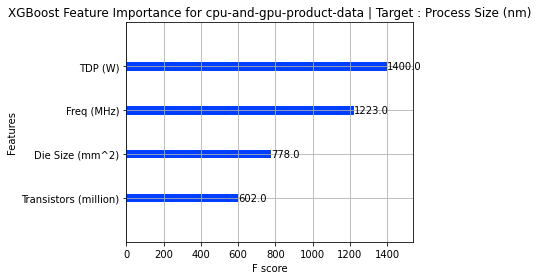

<Figure size 432x288 with 0 Axes>

In [22]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

                 feature  importance
0                TDP (W)     1400.00
1        Die Size (mm^2)      778.00
2  Transistors (million)      602.00
3             Freq (MHz)     1223.00
0      Process Size (nm)      772.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

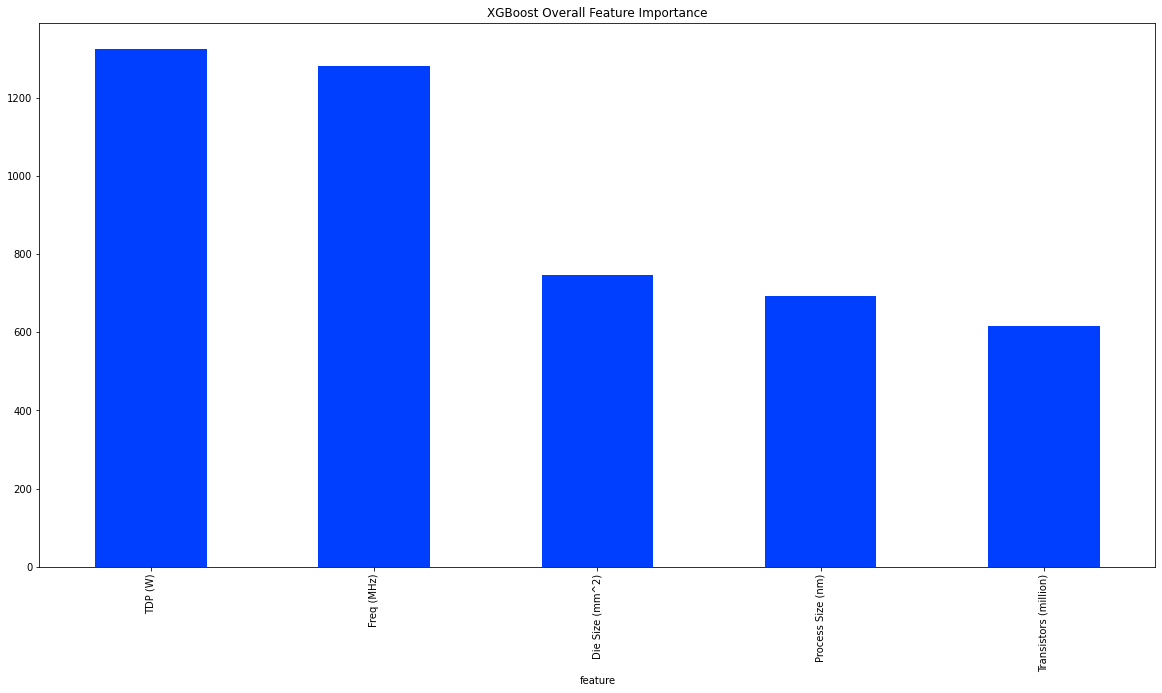

In [23]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [24]:
df.isna().sum()

Type                        0
Process Size (nm)           0
TDP (W)                     0
Die Size (mm^2)             0
Transistors (million)       0
Freq (MHz)                  0
Foundry                  1421
Vendor                      0
dtype: int64

# **To Be Continued...**